### This notebook prepares graphs and training csv's for milestone 3
- prereq: have the meter occupancies including the mobile transactions generated

In [1]:
import pandas as pd
import math
import numpy as np
import datetime
import time
import os

In [2]:
#walk through all of the oakland files and pull them into a dictionary
OAKLAND_ZONES = [
    '407 - Oakland 1',
    '408 - Oakland 2',
    '409 - Oakland 3',
    '410 - Oakland 4'
]

meter_dfs = {}
for zone in OAKLAND_ZONES:
    path = '../data/meter_occupancies_with_mobile/' + zone
    for root, dirs, files in os.walk(path):
        for file in files:
            file_name = path + '/' + file
            df = pd.read_csv(file_name)
            
            #capacity is defined as the 90th percentile of all non-zero 'used spaces' at a meter over the course of the year
            df['total_spaces'] = df[df['used_spaces'] != 0]['used_spaces'].quantile(.90)
            
            #occuapncy - the percentage of spots that are occupied AKA NOT AVAILABLE
            df['occupancy'] = (df['used_spaces'] / df['total_spaces']).round(3)
            
            #occupancy is capped at 1
            temp = df['occupancy']
            temp[temp > 1] = 1
            df['occupancy'] = temp
            
            meter = file.split('.')[0]
            meter_dfs[meter] = df


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
all_meters = pd.concat(meter_dfs.values(), ignore_index = True, keys=None)
all_meters = all_meters.sort_values(by='start')
all_meters

,meter,zone,start,day_of_week,date,month,time,is_holiday,used_spaces,total_spaces,occupancy
0,407136-DARAGH0306,407 - Oakland 1,2018-01-01 00:00:00-05:00,Monday,2018-01-01,1,00:00:00,True,0.0,13.0,0.0
5256000,409284-RUSKIN0102,409 - Oakland 3,2018-01-01 00:00:00-05:00,Monday,2018-01-01,1,00:00:00,True,0.0,14.0,0.0
2838240,408193-5THAVE4201,408 - Oakland 2,2018-01-01 00:00:00-05:00,Monday,2018-01-01,1,00:00:00,True,0.0,10.0,0.0
840960,407112-FORBES3601,407 - Oakland 1,2018-01-01 00:00:00-05:00,Monday,2018-01-01,1,00:00:00,True,0.0,12.0,0.0
7989120,410191-FORBES4004,410 - Oakland 4,2018-01-01 00:00:00-05:00,Monday,2018-01-01,1,00:00:00,True,0.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5939279,409249-NCRAIG0102,409 - Oakland 3,2018-12-31 23:50:00-05:00,Monday,2018-12-31,12,23:50:00,False,0.0,10.0,0.0
5886719,409302-FILMOR4501,409 - Oakland 3,2018-12-31 23:50:00-05:00,Monday,2018-12-31,12,23:50:00,False,0.0,6.0,0.0
5834159,409248-NCRAIG0101,409 - Oakland 3,2018-12-31 23:50:00-05:00,Monday,2018-12-31,12,23:50:00,False,0.0,10.0,0.0
6254639,409303-FILMOR4601,409 - Oakland 3,2018-12-31 23:50:00-05:00,Monday,2018-12-31,12,23:50:00,False,0.0,6.0,0.0


In [4]:
import seaborn as sb
from matplotlib import pyplot as plt

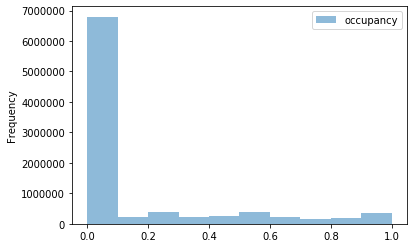

In [50]:
occ = pd.DataFrame(all_meters['occupancy'])
ax = occ.plot.hist(bins=10, alpha=0.5)

In [9]:
meters_non_zeros = all_meters[all_meters['used_spaces'] != 0]

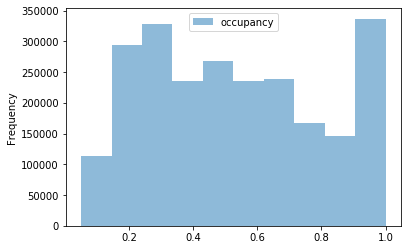

In [52]:
occ = pd.DataFrame(meters_non_zeros['occupancy'])
ax = occ.plot.hist(bins=10, alpha=0.5)

### We are interested in several different training files
- All only use OAKLAND meters
- All are going to use the mobile transaction ratio dispersion method from meter_occupancy.ipynb
- All also use the 90th percentile method from above in this file
- They are different as follows:
   - One will include ALL time buckets - even overnight ones
   - One will include only times from witihin the hours of 6AM - 6PM to help eliminate some of the zeros
   - Any others we think of? maybe one without zeros?

In [55]:
#Training file 1: all buckets (nice and easy thankfully)
all_meters.to_csv('../data/OAKLAND_with_mobile_occupancies.csv', index=False)

In [ ]:
g = sb.FacetGrid(all_meters, col='meter', col_wrap=10)
g.map(plt.hist, 'occupancy')
plt.show

In [73]:
#Trainign file 2: only buckets between dusk and dawn
trainer_2 = all_meters
trainer_2['time'] = pd.to_datetime(trainer_2['time'])

#keep buckets that happen before dusk
dusk = pd.Timestamp('18:00:00')
trainer_2 = trainer_2[trainer_2['time'] < dusk]

#keep buckets that happen after dawn
dawn = pd.Timestamp('06:00:00')
trainer_2 = trainer_2[trainer_2['time'] >= dawn]

trainer_2['time'] = trainer_2['time'].dt.time
trainer_2

trainer_2.to_csv('../data/OAKLAND_6am_to_6pm_occupancies.csv', index=False)

<function matplotlib.pyplot.show(*args, **kw)>

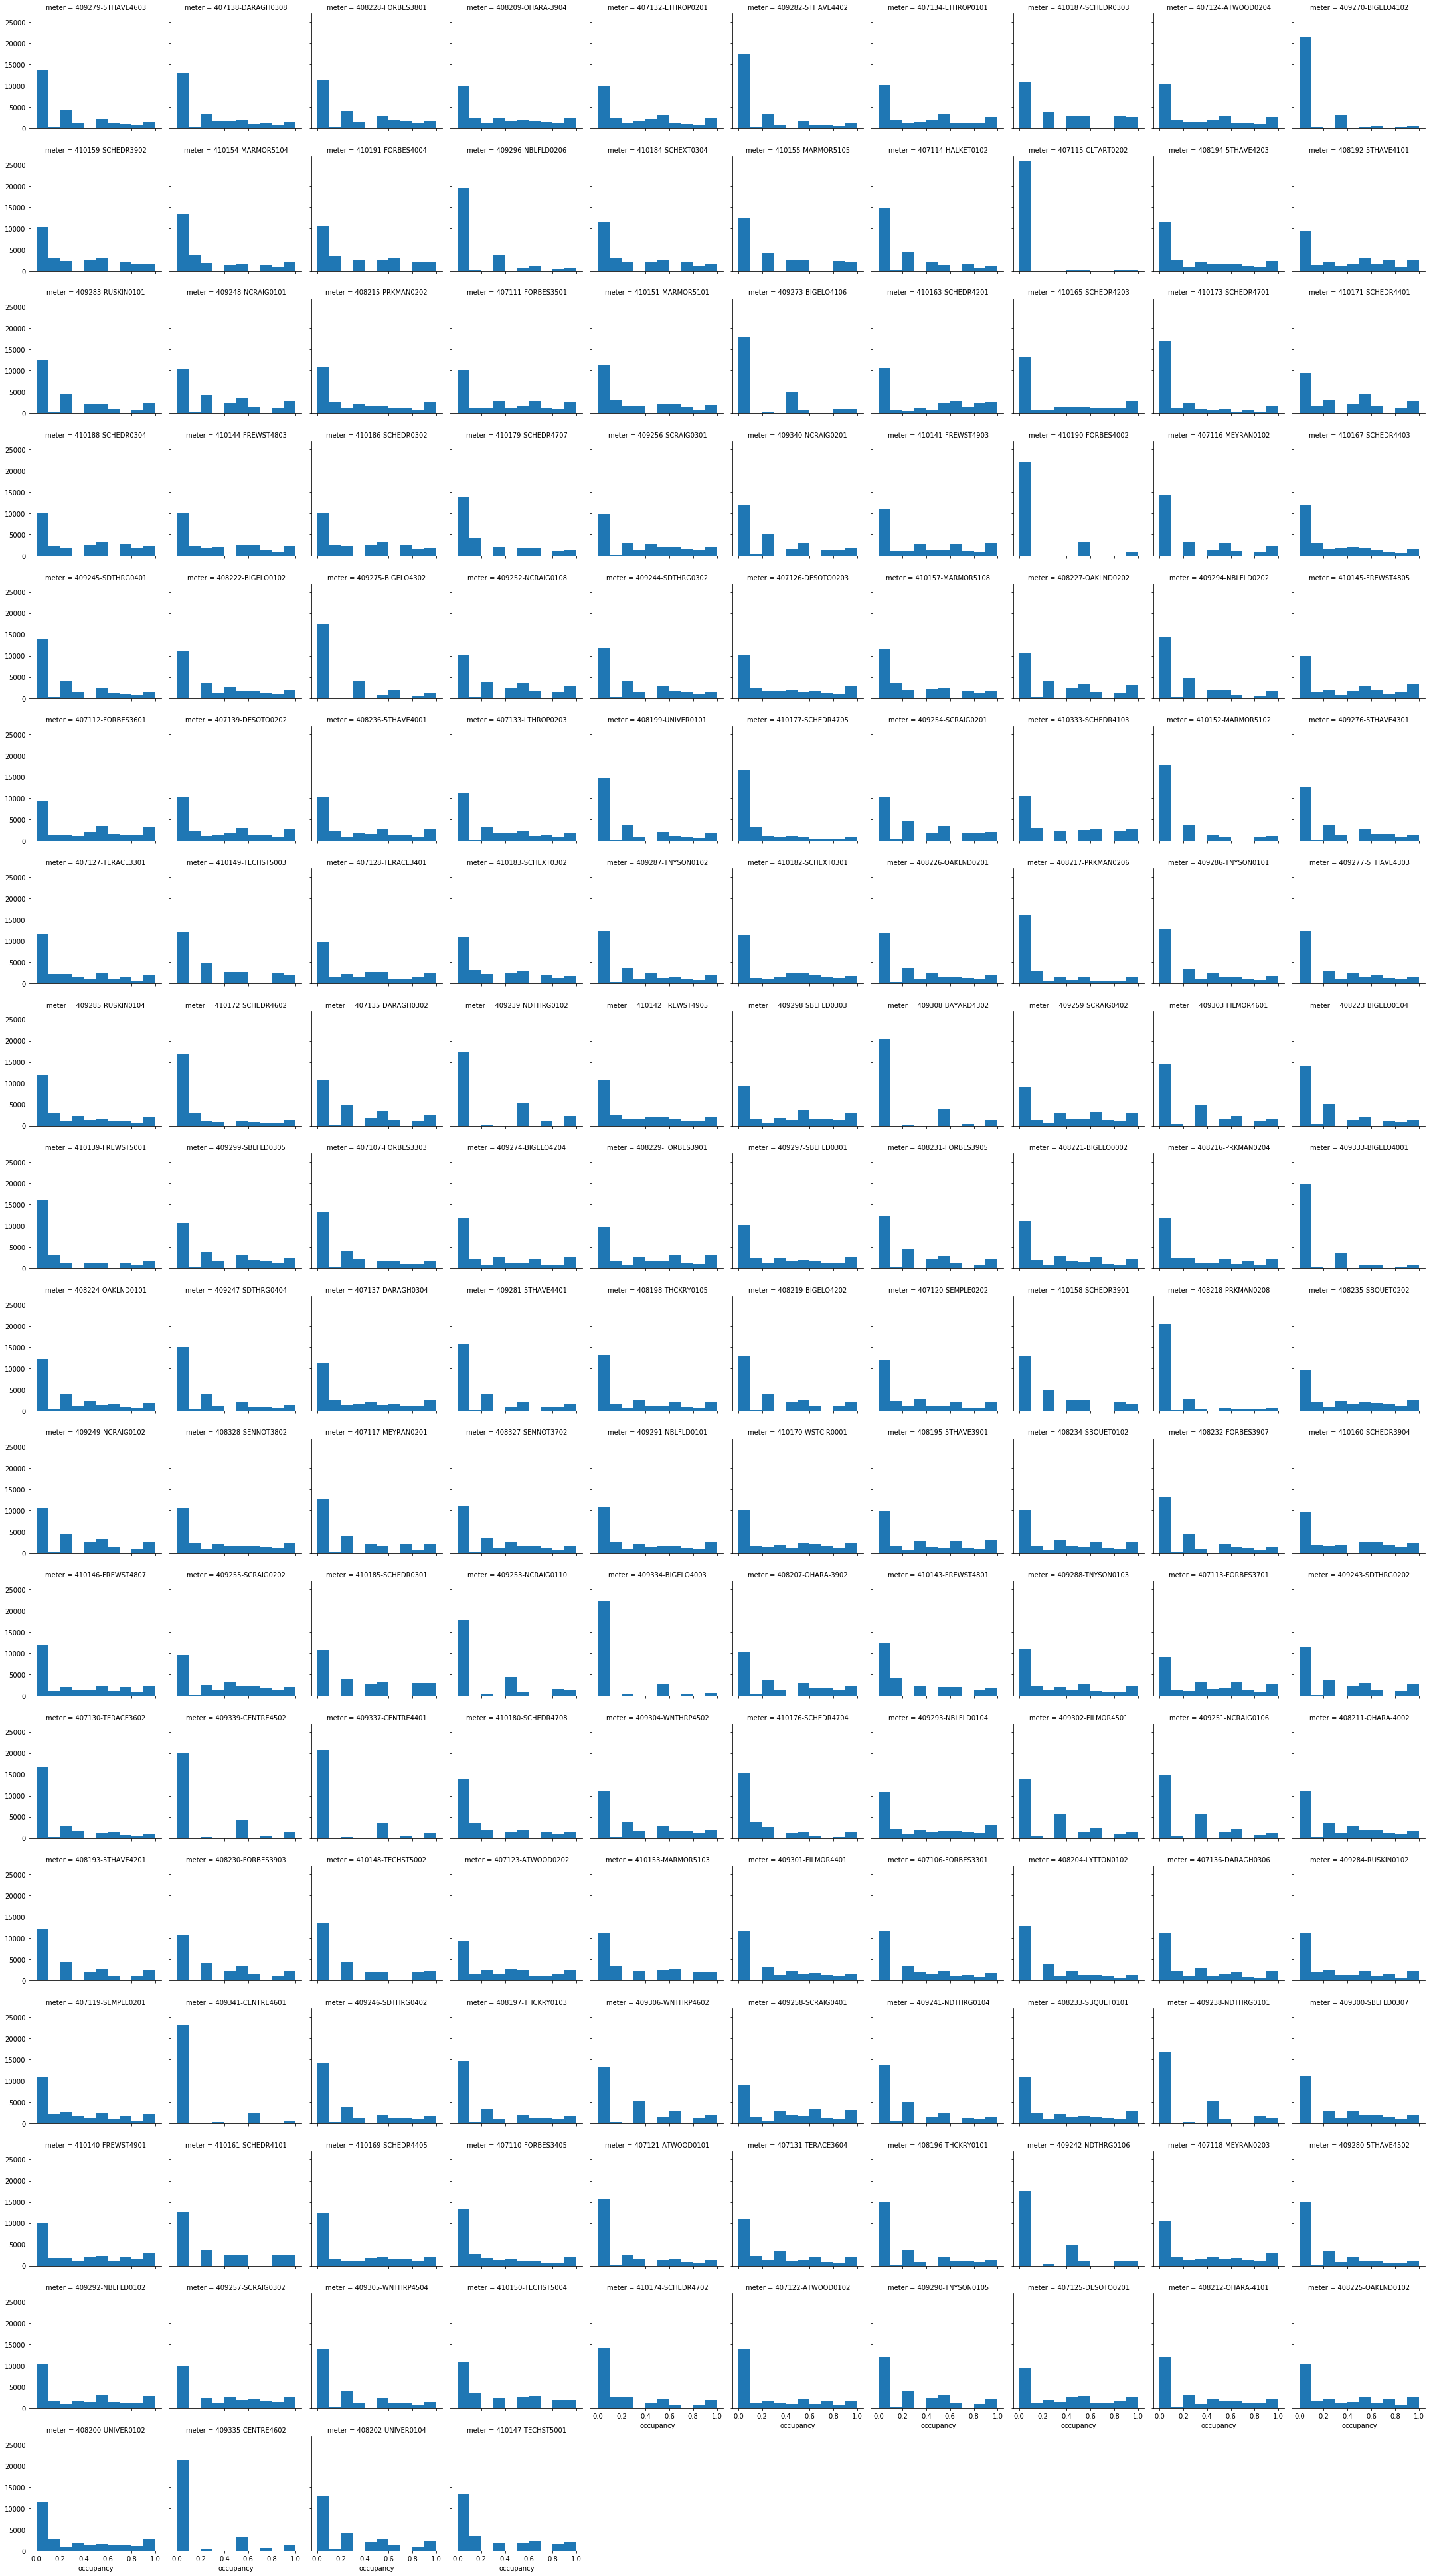

In [74]:
g = sb.FacetGrid(trainer_2, col='meter', col_wrap=10)
g.map(plt.hist, 'occupancy')
plt.show

In [6]:
#Trainer 3file 3: potentially use the non-zero transactions.  
#undefined model behavior however for buckets that never had a parked car
meters_non_zeros.to_csv('../data/OAKLAND_non_zero_buckets.csv', index=False)

In [ ]:
g = sb.FacetGrid(meters_non_zeros, col='meter', col_wrap=10)
g.map(plt.hist, 'occupancy')
plt.show

### Model comparisons and validation
 - We want to take a random sample of the buckets to create a common test set (unfortunately didn't do this for training but oh well)
 - We'll get the predictions for each of the three models and compare the distributions
 - Also compare to the "true" value

In [46]:
# Going to test the third week in November because that's what we use for the presentation
start = '11-11-2018'
end = '11-18-2018'
meters_non_zeros['date'] = pd.to_datetime(meters_non_zeros['date'])
test_set = meters_non_zeros[meters_non_zeros['date'] >= start]
test_set = test_set[test_set['date'] < end]
test_set = test_set.sample(25, random_state=1)
test_set['non_mobile_prediction'] = 0
test_set['inc_mobile_prediction'] = 0
test_set['non_zero_prediction'] = 0
test_set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,meter,zone,start,day_of_week,date,month,time,is_holiday,used_spaces,total_spaces,occupancy,non_mobile_prediction,inc_mobile_prediction,non_zero_prediction
8297773,410143-FREWST4801,410 - Oakland 4,2018-11-15 10:10:00-05:00,Thursday,2018-11-15,11,10:10:00,False,3.0,6.0,0.500,0,0,0
8560443,410141-FREWST4903,410 - Oakland 4,2018-11-14 12:30:00-05:00,Wednesday,2018-11-14,11,12:30:00,False,8.0,13.0,0.615,0,0,0
5512117,409288-TNYSON0103,409 - Oakland 3,2018-11-15 14:10:00-05:00,Thursday,2018-11-15,11,14:10:00,False,13.0,12.0,1.000,0,0,0
8718268,410142-FREWST4905,410 - Oakland 4,2018-11-15 12:40:00-05:00,Thursday,2018-11-15,11,12:40:00,False,2.0,9.0,0.222,0,0,0
1307284,407106-FORBES3301,407 - Oakland 1,2018-11-15 08:40:00-05:00,Thursday,2018-11-15,11,08:40:00,False,3.0,9.0,0.333,0,0,0
3935589,409305-WNTHRP4504,409 - Oakland 3,2018-11-17 11:30:00-05:00,Saturday,2018-11-17,11,11:30:00,False,2.0,8.0,0.250,0,0,0
8665846,410150-TECHST5004,410 - Oakland 4,2018-11-16 11:40:00-05:00,Friday,2018-11-16,11,11:40:00,False,4.0,6.0,0.667,0,0,0
729437,407124-ATWOOD0204,407 - Oakland 1,2018-11-17 12:50:00-05:00,Saturday,2018-11-17,11,12:50:00,False,15.0,12.0,1.000,0,0,0
7456540,410187-SCHEDR0303,410 - Oakland 4,2018-11-13 12:40:00-05:00,Tuesday,2018-11-13,11,12:40:00,False,4.0,5.0,0.800,0,0,0
7667078,410160-SCHEDR3904,410 - Oakland 4,2018-11-15 14:20:00-05:00,Thursday,2018-11-15,11,14:20:00,False,7.0,8.0,0.875,0,0,0


In [47]:
from google.cloud import automl_v1beta1 as automl
from google.oauth2 import service_account

In [48]:
PROJECT_ID = 'pittparkingpal'
COMPUTE_REGION = 'us-central1'

non_mobile = 'oakland_meter_non_20201014023202'
inc_mobile = 'oakland_meter_mob_20201101112459'
non_zero = 'oakland_non_zero__20201108125857'

client = automl.TablesClient(
    project=PROJECT_ID, 
    region=COMPUTE_REGION,
    credentials=service_account.Credentials.from_service_account_file('../ParkingPalApp/app/data/PittParkingPal-9d5a9e2d9504.json')
)

In [49]:
def get_prediction(inputs, model):
    response = client.predict(
        model_display_name=model,
        inputs=inputs
    )
    # this assumes we only recieve one result
    return response.payload[0].tables.value

In [54]:
#we need to use iloc to store things back which is kind of a pain
for i in range(0, 25):
    sample = test_set.iloc[i]
    inputs = {
        'day_of_week': sample['day_of_week'],
        'is_holiday': str(sample['is_holiday']),
        'meter': sample['meter'],
        'month': int(sample['month']),
        'time': sample['time'],
        'zone': sample['zone']
    }
    #test_set.iloc[i, -3] = get_prediction(inputs, non_mobile)
    test_set.iloc[i, -2] = get_prediction(inputs, inc_mobile)
    #test_set.iloc[i, -1] = get_prediction(inputs, non_zero)

test_set

,meter,zone,start,day_of_week,date,month,time,is_holiday,used_spaces,total_spaces,occupancy,non_mobile_prediction,inc_mobile_prediction,non_zero_prediction
8297773,410143-FREWST4801,410 - Oakland 4,2018-11-15 10:10:00-05:00,Thursday,2018-11-15,11,10:10:00,False,3.0,6.0,0.500,0.123947,0.420969,0.524141
8560443,410141-FREWST4903,410 - Oakland 4,2018-11-14 12:30:00-05:00,Wednesday,2018-11-14,11,12:30:00,False,8.0,13.0,0.615,0.258709,0.647451,0.646097
5512117,409288-TNYSON0103,409 - Oakland 3,2018-11-15 14:10:00-05:00,Thursday,2018-11-15,11,14:10:00,False,13.0,12.0,1.000,0.231184,0.623731,0.548179
8718268,410142-FREWST4905,410 - Oakland 4,2018-11-15 12:40:00-05:00,Thursday,2018-11-15,11,12:40:00,False,2.0,9.0,0.222,0.281190,0.586456,0.580861
1307284,407106-FORBES3301,407 - Oakland 1,2018-11-15 08:40:00-05:00,Thursday,2018-11-15,11,08:40:00,False,3.0,9.0,0.333,0.119442,0.477655,0.552851
3935589,409305-WNTHRP4504,409 - Oakland 3,2018-11-17 11:30:00-05:00,Saturday,2018-11-17,11,11:30:00,False,2.0,8.0,0.250,0.048289,0.130753,0.355367
8665846,410150-TECHST5004,410 - Oakland 4,2018-11-16 11:40:00-05:00,Friday,2018-11-16,11,11:40:00,False,4.0,6.0,0.667,0.203554,0.467142,0.640958
729437,407124-ATWOOD0204,407 - Oakland 1,2018-11-17 12:50:00-05:00,Saturday,2018-11-17,11,12:50:00,False,15.0,12.0,1.000,0.294191,0.466438,0.554677
7456540,410187-SCHEDR0303,410 - Oakland 4,2018-11-13 12:40:00-05:00,Tuesday,2018-11-13,11,12:40:00,False,4.0,5.0,0.800,0.221890,0.591993,0.672772
7667078,410160-SCHEDR3904,410 - Oakland 4,2018-11-15 14:20:00-05:00,Thursday,2018-11-15,11,14:20:00,False,7.0,8.0,0.875,0.308729,0.680733,0.682210


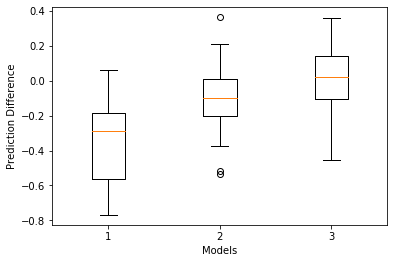

In [62]:
#boxplot creation
data = [
    test_set['non_mobile_prediction'] - test_set['occupancy'],
    test_set['inc_mobile_prediction'] - test_set['occupancy'],
    test_set['non_zero_prediction'] - test_set['occupancy']
]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xlabel('Models')
ax.set_ylabel('Prediction Difference')
plt.show()